# LR Sweep

Currently implemented for CIFAR-100 training.

There's always so much optimizer state that breaks when LR sweeping, easier to do in a separate script.

In [1]:
import numpy as np
import torch as t
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

from datasets import DatasetDict, load_dataset
from nanovit import ViT, ViTConfig, build_preprocessor

device = "cuda" if t.cuda.is_available() else "cpu"

## CIFAR-100 Setup

Equivalent config (2.7M params)

In [2]:
vit_cfg = ViTConfig(
    n_layers=6,
    d_model=192,
    d_proj=100,
    image_res=(32, 32),
    patch_size=4,
    n_heads=8,
    dropout=0.1,
    norm_data=(
        (0.48145466, 0.4578275, 0.40821073),
        (0.26862954, 0.26130258, 0.27577711),
    ),
    mlp_mult=4,
)
vit = ViT(vit_cfg).to(device)
vit.init_weights_()

preproc = build_preprocessor(vit_cfg)

Not sure if I add xfms, but I don't think it should make a huge difference.

In [ ]:
dd: DatasetDict = load_dataset("uoft-cs/cifar100")  # type: ignore

def collate_fn(batch: list[dict]):
    pixel_values = t.stack([preproc(x["img"]) for x in batch])
    labels = t.tensor([x["fine_label"] for x in batch])
    return pixel_values, labels

dl = DataLoader(dd["train"], batch_size=256, collate_fn=collate_fn) # type: ignore


## Impl

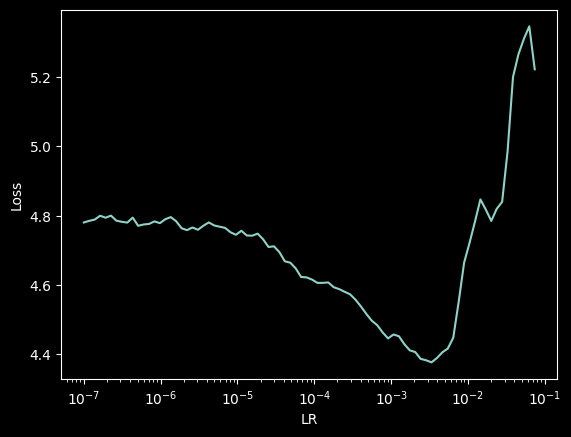

In [4]:
def _plot_losses(lrs, losses):
    fig, ax = plt.subplots()
    ax.plot(lrs, losses)
    ax.set_xscale("log")
    ax.set_xlabel("LR")
    ax.set_ylabel("Loss")
    plt.show()


def smooth_losses(losses, window_size=5):
    kernel = np.ones(window_size) / window_size
    return np.convolve(losses, kernel, mode="valid")


def lr_sweep(
    model,
    opt_cls,
    dl,
    step_func,
    start_lr: float = 1e-7,
    end_lr: float = 1.0,
    steps: int = 500,
):
    """
    step_func should take a model and a batch and return a loss and any other metrics
    """
    opt = opt_cls(model.parameters(), lr=start_lr)
    lrs = t.logspace(np.log10(start_lr), np.log10(end_lr), steps)
    assert len(dl) > steps

    best_loss = float("inf")
    losses = []
    for lr, batch in zip(tqdm(lrs, leave=False), dl):
        loss, *_ = step_func(model, batch)

        opt.param_groups[0]["lr"] = lr
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())
        if t.isnan(loss) or loss > best_loss * 4:
            break
        best_loss = min(best_loss, loss.item())
    losses = smooth_losses(losses)
    _plot_losses(lrs[: len(losses)], losses)


def single_step(model, batch):
    pixel_values, labels = batch
    pixel_values, labels = pixel_values.to(device), labels.to(device)
    with t.autocast(device_type=device):
        logits = model(pixel_values)
        loss = t.nn.functional.cross_entropy(logits, labels)

    if labels.ndim != 1:  # mixup/cutmix
        labels = labels.argmax(dim=-1)

    accuracy = (logits.argmax(dim=-1) == labels).float().mean()
    return loss, accuracy


lr_sweep(vit, t.optim.AdamW, dl, single_step, steps=100)